In [19]:
# This notebook shows the use of a UNet (2DCNN) for predicting weather fronts with model input
# Training uses hand drawn front analysis at 00 & 12UTC with a ~100km untertainty band as labels
# and corresponding ICON vv00 fields of PSML,RH2M,T2M,U10M,V10M and a land-sea mask on ~0.4° horizontal resolution as input.
# Training is logged on mlflow server http://172.16.112.218:5051 ("aifronts_torch_felix")
#
# To train in reasonable time work on gpnl. Therefore
# 1: Start an interactive queue from rcl (terminates after few hours!):
# qlogin -q gp_inter_smc --gpunum-lhost=1 --cpunum-lhost=16 -l memsz_job=240gb -l vmemsz_job=240gb -l vmemsz_prc=240gb
# 2: Load a virtual environment with all neccessary modules:
# source /hpc/uwork/ffundel/venvs/ptnew/bin/activate
# 3: Sart a jupyter notebook:
# jupyter notebook --no-browser --port=1234
# 4: On your local machine establish a ssh tunnel:
# ssh -N -L 1234:localhost:1234   -J rcl gpnl10
# 5: Open link from step 3 in your local browser

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torchmetrics
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4
import math
import numpy as np
import os
import sys
import time
from torchviz import make_dot
import cartopy.crs as ccrs
import mlflow
from datetime import datetime
sys.path.append('/hpc/uhome/ffundel/repos/ai-fronts/scripts')
import unet
import importlib
importlib.reload(unet)

<module 'unet' from '/hpc/uhome/ffundel/repos/ai-fronts/scripts/unet.py'>

In [21]:
# USE GPU IF AVAILABLE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda


In [22]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA A100-SXM4-80GB', major=8, minor=0, total_memory=81050MB, multi_processor_count=108, uuid=fbed0227-afe9-7071-c39a-3fbc07ceabc5, L2_cache_size=40MB)

In [23]:
# INPUT AND LABELS
if os.path.isfile('/hpc/uwork/ffundel/ML/ICON_norm.nc') == False:
    x = xr.open_dataset("/hpc/uwork/ffundel/ML/ICON.nc",  engine="netcdf4")
    #print(x['ICON'][200].shape)
    y = xr.open_dataset("/hpc/uwork/ffundel/ML/FRONTS.nc",  engine="netcdf4")
    #print(y['FRONTS'][200].shape)
    print(y['FRONTS'].values.shape)

In [24]:
# Normalize ICON Input Data
if os.path.isfile('/hpc/uwork/ffundel/ML/ICON_norm.nc') == False:
    means = x.groupby('var').mean(dim=('time','lon','lat'))
    stds  = x.groupby('var').std(dim=('time','lon','lat'))
    x_norm = (x-means)/stds
    x_norm

In [25]:
# Save normalized data to file
if os.path.isfile('/hpc/uwork/ffundel/ML/ICON_norm.nc') == False:
    x_norm.to_netcdf('/hpc/uwork/ffundel/ML/ICON_norm.nc')

In [26]:
# DATA SET FOR DATALOADER
class FrontData(Dataset):
    def __init__(self):
        # Load entire datasets into memory
        self.x = xr.open_dataset("/hpc/uwork/ffundel/ML/ICON_norm.nc", engine="netcdf4")['ICON'].values
        self.y = xr.open_dataset("/hpc/uwork/ffundel/ML/FRONTS.nc", engine="netcdf4")['FRONTS'].values
        self.n_samples = self.y.shape[0]

    def __getitem__(self, index):
        x = torch.tensor(self.x[index], dtype=torch.float)
        y = torch.tensor(self.y[index], dtype=torch.float)
        return x, y

    def __len__(self):
        return self.n_samples

torch.Size([6, 128, 256]) torch.Size([4, 128, 256])


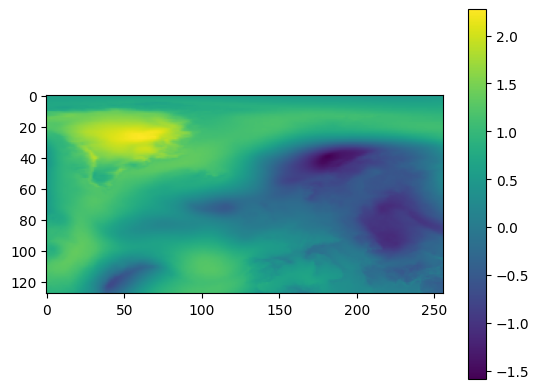

In [27]:
# TEST IF DIMENSIONS ARE IN CORRECT ORDER
dataset = FrontData()
first_data = dataset[0]
features,labels = first_data
#print(features,labels)
print(features.shape,labels.shape)

plt.imshow(features.detach().numpy()[0,::-1,:])
plt.colorbar()

In [28]:
# Load model (this one from the pytorch git works really good)
#model     = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',in_channels=6, out_channels=4, init_features=30, pretrained=False)
model     = unet.UNet(in_channels=6, out_channels=4, init_features=64)
model     = model.to(device) 
# Loss function often used for categorical predictions
loss_fn   = nn.CrossEntropyLoss().to(device)
# Accuracy function
accuracy  = torchmetrics.classification.BinaryAccuracy(threshold=.5).to(device)
# Optimizer and learning rate that works fine here
optimizer = torch.optim.AdamW(params=model.parameters(),lr=0.0001)

In [11]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))
print('param size: {}'.format(param_size))

model size: 118.452MB
param size: 124158224


In [12]:
# Dataloader, for training and validation
torch.manual_seed(0)
train_ratio       = 0.8
validation_ratio  = 0.2
dataset_size      = len(dataset)
train_size        = int(train_ratio * dataset_size)
validation_size   = dataset_size - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size])
train_loader      =  DataLoader(dataset=train_dataset,batch_size=30,shuffle=True,num_workers=6, prefetch_factor=6)
validation_loader =  DataLoader(dataset=validation_dataset,batch_size=30,shuffle=True,num_workers=6, prefetch_factor=6)

In [13]:
# Plot of model structure
train, lab = dataset[1:5]
y = model(train.to(device))
make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True).render("/hpc/uhome/ffundel/repos/ai-fronts/plots/model_architecture", format="png")

'/hpc/uhome/ffundel/repos/ai-fronts/plots/model_architecture.png'

In [14]:
# Training

# For continue training with exisiting model weight load a saved model state
retrain=False
if retrain==True:
    print("Loading existing model weights")
    model.load_state_dict(torch.load('/hpc/uhome/ffundel/repos/ai-fronts/model/best-model-parameters.pt'))


best_avg_vloss = 1000 # high inital value of no further relevance
stp            = 0    # counting indes
stopafter      = 5    # stop training if no improvment for stopafter epochs
max_epochs     = 200  # max number of epochs

# Setup MLflow
# Delete DWD proxys, required to make run MLflow correctly
for i in ("HTTP_PROXY","http_proxy","HTTPS_PROXY","https_proxy"):
    if i in os.environ:
        del os.environ[i]
        
os.environ['MLFLOW_TRACKING_USERNAME'] = 'ffundel'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'mlflowffundel'   
mlflow.end_run()
mlflow.set_tracking_uri("http://172.16.112.218:5051")
mlflow.set_experiment("aifronts_torch_felix")
mlflow.autolog()
run_name = datetime.today().strftime('%Y%m%d%H%M%S')
mlflow.start_run(run_name="unet-"+run_name)


# Training loop
for epoch in range(max_epochs):
    print('EPOCH {}:'.format(epoch + 1))
    running_loss = 0.
    running_acc  = 0.
    model.train(True)
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        outputs   = model(inputs)
        # Compute the loss and its gradients
        loss      = loss_fn(outputs, labels)
        acc       = accuracy(outputs,labels)
        loss.backward()
        # Adjust learning weights
        optimizer.step()
        running_loss += loss.item()
        running_acc  += acc.item()
    avg_loss = running_loss / (i + 1)
    avg_acc  = running_acc / (i + 1)
     
    running_vloss = 0.0
    running_vacc = 0.0
    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            vinputs  = vinputs.to(device)
            vlabels  = vlabels.to(device)
            voutputs = model(vinputs)
            vloss    = loss_fn(voutputs, vlabels)
            vacc     = accuracy(voutputs, vlabels)
            running_vloss += vloss.item()
            running_vacc  += vacc.item()
    avg_vloss = running_vloss / (i + 1)
    avg_vacc = running_vacc / (i + 1)
    print('LOSS train {} valid {} ACC train {} valid {}'.format(round(avg_loss,3), round(avg_vloss,3), round(avg_acc,3), round(avg_vacc,3)))

    # Log metrics to mlflow server
    mlflow.log_metric("train_loss",     f"{avg_loss:2f}",  step=epoch)
    mlflow.log_metric("train_accuracy", f"{avg_acc:2f}",   step=epoch)    
    mlflow.log_metric("eval_loss",      f"{avg_vloss:2f}", step=epoch)
    mlflow.log_metric("eval_accuracy",  f"{avg_vacc:2f}",  step=epoch)

    # Save best validating model
    if avg_vloss < best_avg_vloss:
        stp = 0 
        print('Saving current model')
        best_avg_vloss = avg_vloss
        torch.save(model.state_dict(), '/hpc/uhome/ffundel/repos/ai-fronts/model/best-model-parameters.pt')
    else:
        stp += 1

    if stp>=stopafter:
        break
    

EPOCH 1:
LOSS train 1.226 valid 1.153 ACC train 0.851 valid 0.898
Saving current model
EPOCH 2:
LOSS train 1.108 valid 1.062 ACC train 0.92 valid 0.941
Saving current model
EPOCH 3:
LOSS train 1.046 valid 1.024 ACC train 0.945 valid 0.951
Saving current model
EPOCH 4:
LOSS train 0.998 valid 0.978 ACC train 0.954 valid 0.957
Saving current model
EPOCH 5:
LOSS train 0.959 valid 0.943 ACC train 0.96 valid 0.961
Saving current model
EPOCH 6:
LOSS train 0.929 valid 0.914 ACC train 0.962 valid 0.963
Saving current model
EPOCH 7:
LOSS train 0.904 valid 0.899 ACC train 0.964 valid 0.964
Saving current model
EPOCH 8:
LOSS train 0.886 valid 0.883 ACC train 0.965 valid 0.964
Saving current model
EPOCH 9:
LOSS train 0.872 valid 0.87 ACC train 0.966 valid 0.964
Saving current model
EPOCH 10:
LOSS train 0.86 valid 0.861 ACC train 0.967 valid 0.964
Saving current model
EPOCH 11:
LOSS train 0.851 valid 0.854 ACC train 0.967 valid 0.964
Saving current model
EPOCH 12:
LOSS train 0.842 valid 0.849 ACC tr

In [15]:
# Load trained model for test inference
best_model     = unet.UNet(in_channels=6, out_channels=4, init_features=64)
best_model.load_state_dict(torch.load('/hpc/uhome/ffundel/repos/ai-fronts/model/best-model-parameters.pt'))

<All keys matched successfully>

In [16]:
# Inference with validation data
model.eval()
inputs,labels = validation_dataset[0:12]
print(inputs.shape)
inference     = model(inputs.to(device))

torch.Size([12, 6, 128, 256])


torch.Size([12, 4, 128, 256])


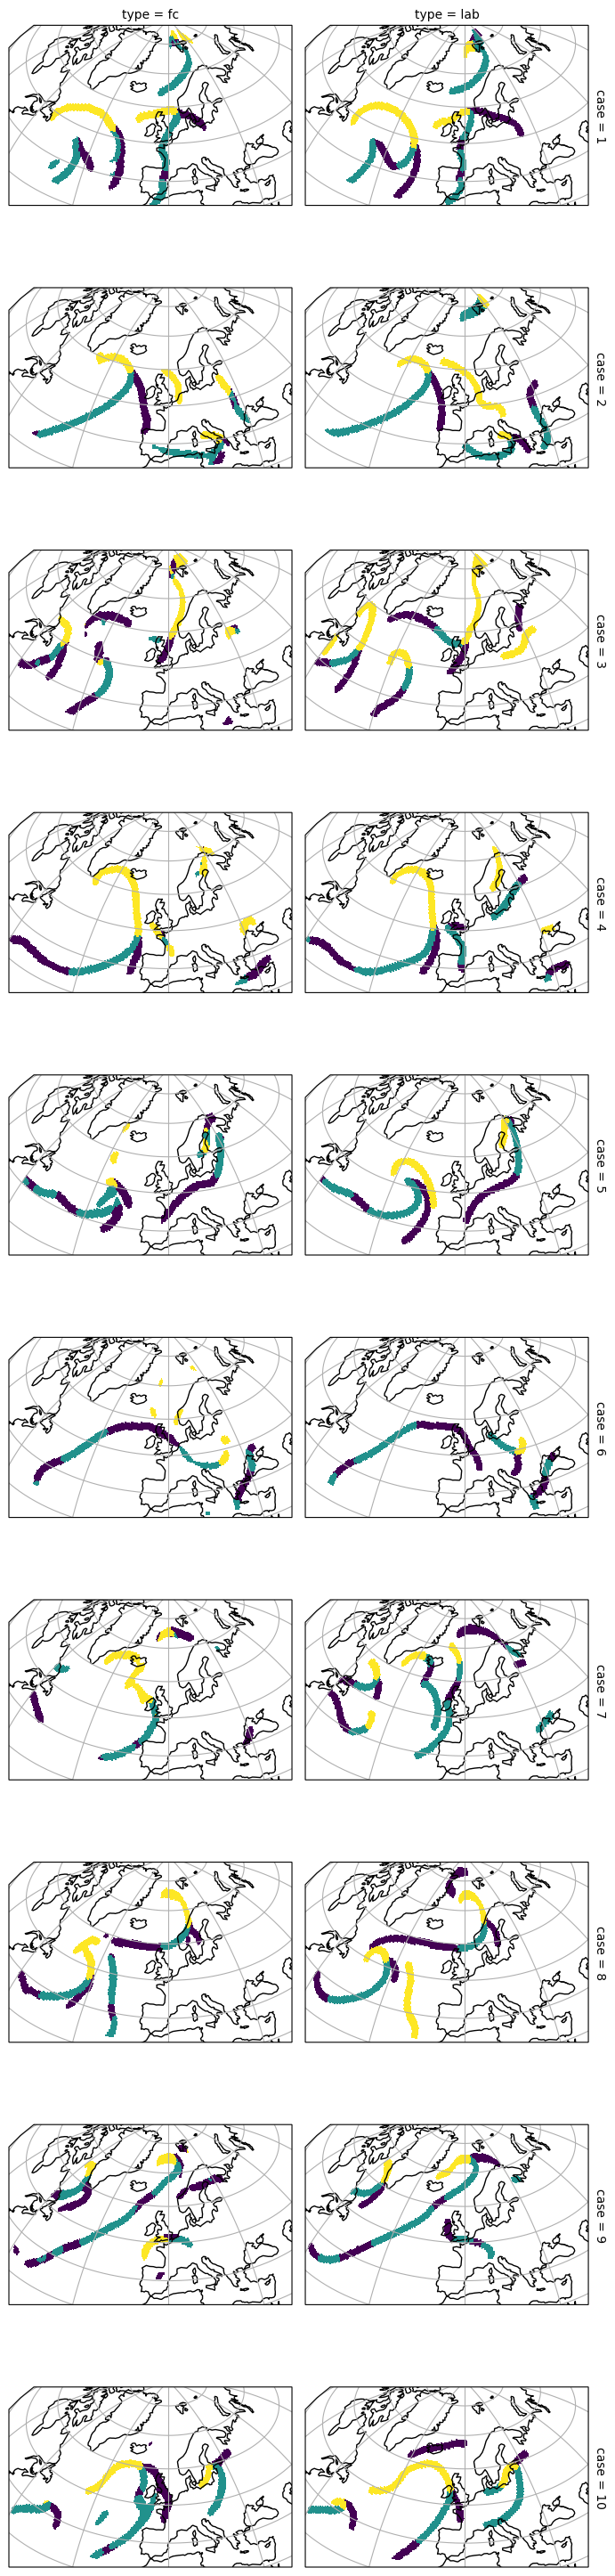

In [17]:
# Plot some cases from the validation dataset
cases         = [1,2,3,4,5,6,7,8,9,10]
print(inference.shape)

# Forecast pre-processing
fc          = np.array(inference.cpu().detach().numpy()[cases,:,:,:])
fc[:,3,:,:] = np.where(fc[:,3,:,:]>.8,fc[:,3,:,:],np.nan)
fc          = np.nanargmax(fc,axis=1)
fc          = np.where(fc==3, np.nan, fc)

# Label pre-processing
lab          = np.array(labels.detach().numpy()[cases,:,:,:])
lab[:,3,:,:] = np.where(lab[:,3,:,:]>.8,lab[:,3,:,:],np.nan)
lab          = np.nanargmax(lab,axis=1)
lab          = np.where(lab==3, np.nan, lab)

# To xarray
coords       = {'type':['fc','lab'],'case':cases,'latitude': np.linspace(34,85,128),'longitude':np.linspace(-60,42,256)}
arr          = xr.DataArray([fc,lab],coords)

# Plot
p = arr.plot(add_colorbar=False,transform=ccrs.PlateCarree(),subplot_kws={"projection": ccrs.Orthographic(0, 35)},cmap=plt.cm.viridis,levels=4,col="type",row="case")
[ax.coastlines() for ax in p.axs.flatten()]
[ax.gridlines()  for ax in p.axs.flatten()]
plt.savefig('/hpc/uhome/ffundel/repos/ai-fronts/plots/validation_examples.png')

# Log plot on mlflow
mlflow.log_artifact("/hpc/uhome/ffundel/repos/ai-fronts/plots/validation_examples.png")

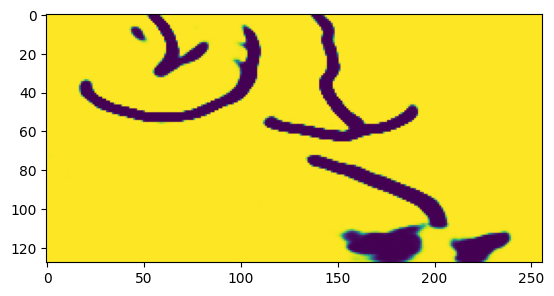

In [18]:
fc          = np.array(inference.cpu().detach().numpy()[cases,:,:,:])
plt.imshow(fc[0,3,:,:])